<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_latent_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 1: Python Preliminaries**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 7 Material

* Part 7.1: Introduction to GANs for Image and Data Generation [[Video]](https://www.youtube.com/watch?v=hZw-AjbdN5k&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_1_gan_intro.ipynb)
* Part 7.2: Train StyleGAN3 with your Own Images [[Video]](https://www.youtube.com/watch?v=R546LYsQk5M&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_train_gan.ipynb)
* **Part 7.3: Exploring the StyleGAN Latent Vector** [[Video]](https://www.youtube.com/watch?v=goQzp8QSb2s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_latent_vector.ipynb)
* Part 7.4: GANs to Enhance Old Photographs Deoldify [[Video]](https://www.youtube.com/watch?v=0OTd5GlHRx4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_4_deoldify.ipynb)
* Part 7.5: GANs for Tabular Synthetic Data Generation [[Video]](https://www.youtube.com/watch?v=yujdA46HKwA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_5_tabular_synthetic.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [ ]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


# Part 7.3: Exploring the StyleGAN Latent Vector

StyleGAN seeds, such as 3000, are only random number seeds used to generate much longer 512-length latent vectors, which create the GAN image.  If you make a small change to the seed, for example, change 3000 to 3001, StyleGAN will create an entirely different picture.  However, if you make a small change to a few latent vector values, the image will only change slightly.  In this part, we will see how we can fine-tune the latent vector to control, to some degree, the resulting GAN image appearance.

## Installing Needed Software

We begin by installing StyleGAN.

In [ ]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 34.36 MiB/s, done.
Resolving deltas: 100% (108/108), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 7.9 MB/s eta 0:00:00


We will use the same functions introduced in the previous part to generate GAN seeds and images.

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy
import time

In [ ]:


def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
        nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class'\
                   'when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running '\
            'on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0,
                   noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi,
          noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128)\
    .clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

Next, we load the NVIDIA FFHQ (faces) GAN.  We could use any StyleGAN pretrained GAN network here.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_PATH = "/content/drive/My Drive/MA/model/network-snapshot-005000.pkl"

In [ ]:

print(f'Loading networks from" {MODEL_PATH}"...' )
device = torch.device('cuda')
# The file object 'f' should be passed to load_network_pkl
# instead of the BytesIO object 'fp'.
with open(MODEL_PATH, 'rb') as f:  # Open in binary read mode ('rb')
    G = legacy.load_network_pkl(f)['G_ema']\
      .requires_grad_(False).to(device)

Loading networks from" /content/drive/My Drive/MA/model/network-snapshot-005000.pkl"...


Seed 4020
Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


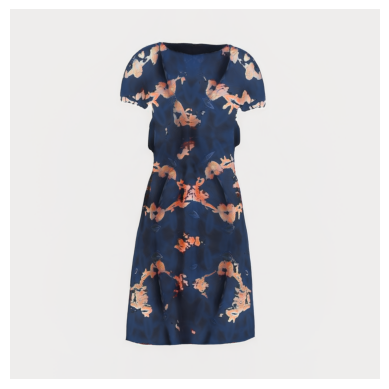

Seed 4021


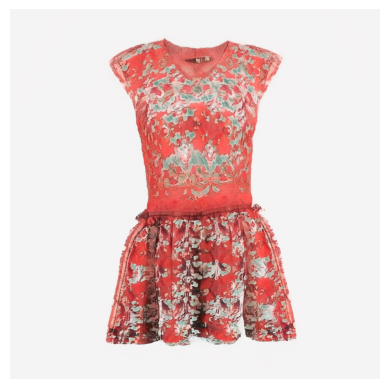

Seed 4022


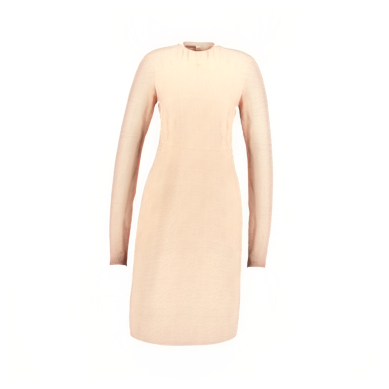

In [ ]:
# HIDE OUTPUT 1
# Choose your own starting and ending seed.
SEED_FROM = 4020
SEED_TO = 4023

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## Fine-tune an Image

If you find a seed you like, you can fine-tune it by directly adjusting the latent vector.  First, choose the seed to fine-tune.

In [ ]:
START_SEED = 3070

current = seed2vec(G, START_SEED)

Next, generate and display the current vector. You will return to this point for each iteration of the finetuning.

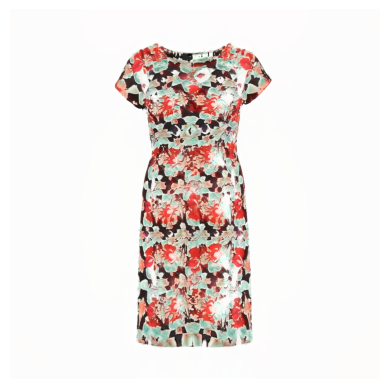

In [ ]:
img = generate_image(device, G, current)

SCALE = 0.5
display_image(img)

Choose an explore size; this is the number of different potential images chosen by moving in 10 different directions.  Run this code once and then again anytime you wish to change the ten directions you are exploring.  You might change the ten directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Each image displayed from running this code shows a potential direction that we can move in the latent vector.  Choose one image that you like and change MOVE_DIRECTION to indicate this decision.  Once you rerun the code, the code will give you a new set of potential directions.  Continue this process until you have a latent vector that you like.

In [ ]:
# HIDE OUTPUT 1
# Choose the direction to move.  Choose -1 for the initial iteration.
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  z = current + mv
  img = generate_image(device, G, z)
  display_image(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# HIDE OUTPUT 1
# Choose the direction to move.  Choose -1 for the initial iteration.
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >= 0:
  current = current + explore[MOVE_DIRECTION]

# Calculate grid dimensions
num_images = len(explore)
cols = 5  # Number of columns in the grid
rows = (num_images + cols - 1) // cols  # Number of rows, calculated to fit all images

# Create a figure and axes for the grid
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))  # Adjust figsize as needed

# Create a unique folder name using timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
output_folder = f"/content/drive/My Drive/MA/output_images/{timestamp}"

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Iterate and display images in the grid
for i, mv in enumerate(explore):
  z = current + mv
  img = generate_image(device, G, z)
  # Calculate distance from original image
  distance = np.linalg.norm(z - current)  # Euclidean distance
  # Use distance as part of the filename
  img.save(f"{output_folder}/image_distance_{distance:.2f}.png")
  # Calculate row and column index for the current image
  row_idx = i // cols
  col_idx = i % cols

  # Display the image on the corresponding subplot
  ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]  # Handle single row case
  ax.imshow(np.array(img))  # Convert PIL Image to NumPy array for imshow
  ax.axis('off')
  #ax.set_title(f"Direction {i}")  # Remove or comment out to hide titles

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [47]:
!cd '/content/drive/My Drive/MA'

In [48]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/My Drive/MA/.git/


In [49]:
!touch .gitignore

In [30]:
!echo "model/" >> .gitignore

In [ ]:
!echo "Orga/" >> .gitignore

In [50]:
!git remote add origin https://github.com/blackSwan566/Generative_fashion_eeg.git

In [51]:
!git checkout -b development

Switched to a new branch 'development'


In [53]:
! git add .

error: open("Orga/ To-do-Liste kw 17.gsheet"): Operation not supported
error: unable to index file 'Orga/ To-do-Liste kw 17.gsheet'
fatal: adding files failed
